In [19]:
import os
from os.path import join
import gc
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(ROOT_DIR,'py'))

import util

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [2]:
# Define the path to the data folder
WEEK = 7
DATA_DIR = "../data/"
WEEKS = range(WEEK, WEEK+1)

df_game = pd.read_csv(join(DATA_DIR, "games.csv"))
df_play = pd.read_csv(join(DATA_DIR, "plays.csv"))
df_player_play = pd.read_csv(join(DATA_DIR, "player_play.csv"))
df_player = pd.read_csv(join(DATA_DIR, "players.csv"))

tracking_dfs = []
for wk in tqdm(WEEKS, desc="Loading tracking files"):
    df = pd.read_csv(join(DATA_DIR, f'tracking_week_{wk}.csv'))
    if 'week' not in df.columns:
        df.insert(3,'week',wk)
    tracking_dfs.append(df)
    
df_tracking = pd.concat(tracking_dfs, axis=0)

del tracking_dfs

Loading tracking files: 100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


In [3]:

util.uncamelcase_columns(df_game)
util.uncamelcase_columns(df_player)
util.uncamelcase_columns(df_play)
util.uncamelcase_columns(df_player_play)
util.uncamelcase_columns(df_tracking)

# standardize direction to be offense moving right
df_tracking, df_play = util.standardize_direction(df_tracking, df_play)

df_game = df_game.query('week==@WEEK').reset_index(drop=True)
game_ids = df_game['game_id'].unique().tolist()
df_player_play = df_player_play.query('game_id in @game_ids').reset_index(drop=True)

In [4]:
df_tracking.head()

game_id  play_id   nfl_id  week  display_name  frame_id   frame_type  \
0  2022102400       66  37087.0     7  Robert Quinn         1  BEFORE_SNAP   
1  2022102400       66  37087.0     7  Robert Quinn         2  BEFORE_SNAP   
2  2022102400       66  37087.0     7  Robert Quinn         3  BEFORE_SNAP   
3  2022102400       66  37087.0     7  Robert Quinn         4  BEFORE_SNAP   
4  2022102400       66  37087.0     7  Robert Quinn         5  BEFORE_SNAP   

                    time  jersey_number club play_direction      x      y  \
0  2022-10-25 00:16:40.6           94.0  CHI          right  27.93  28.63   
1  2022-10-25 00:16:40.7           94.0  CHI          right  27.80  28.63   
2  2022-10-25 00:16:40.8           94.0  CHI          right  27.66  28.63   
3  2022-10-25 00:16:40.9           94.0  CHI          right  27.52  28.63   
4    2022-10-25 00:16:41           94.0  CHI          right  27.37  28.64   

      s     a   dis       o     dir                 event  
0  1.29  0.98  0.12  200.77  179.85  huddle_break_offense  
1  1.38  0.76  0.13  197.13  179.67                   NaN  
2  1.45  0.57  0.14  195.71  178.97                   NaN  
3  1.46  0.27  0.14  195.71  179.12                   NaN  
4  1.46  0.13  0.14  197.27  178.39                   NaN

In [5]:
df_game.head()

game_id  season  week   game_date game_time_eastern home_team_abbr  \
0  2022102000    2022     7  10/20/2022          20:15:00            ARI   
1  2022102300    2022     7  10/23/2022          13:00:00            BAL   
2  2022102301    2022     7  10/23/2022          13:00:00            CAR   
3  2022102302    2022     7  10/23/2022          13:00:00            CIN   
4  2022102303    2022     7  10/23/2022          13:00:00            DAL   

  visitor_team_abbr  home_final_score  visitor_final_score  
0                NO                42                   34  
1               CLE                23                   20  
2                TB                21                    3  
3               ATL                35                   17  
4               DET                24                    6

In [6]:
df_player.head()

nfl_id height  weight  birth_date    college_name position    display_name
0   25511    6-4     225  1977-08-03        Michigan       QB       Tom Brady
1   29550    6-4     328  1982-01-22        Arkansas        T    Jason Peters
2   29851    6-2     225  1983-12-02      California       QB   Aaron Rodgers
3   30842    6-6     267  1984-05-19            UCLA       TE  Marcedes Lewis
4   33084    6-4     217  1985-05-17  Boston College       QB       Matt Ryan

In [7]:
df_play.head()

game_id  play_id                                   play_description  \
0  2022102302     2655  (1:54) (Shotgun) J.Burrow pass short middle to...   
1  2022102306     3240  (12:55) (Shotgun) A.Dillon left tackle to WAS ...   
2  2022102308     3304  (2:57) (No Huddle, Shotgun) D.Mills pass incom...   
3  2022102302     1437  (4:49) T.Allgeier left guard for 1 yard, TOUCH...   
4  2022102000     1707  (1:30) (No Huddle, Shotgun) A.Dalton scrambles...   

   quarter  down  yards_to_go possession_team defensive_team yardline_side  \
0        3     1           10             CIN            ATL           CIN   
1        4     2           10              GB            WAS           WAS   
2        4     2            1             HOU             LV           HOU   
3        2     3            1             ATL            CIN           CIN   
4        2     2            2              NO            ARI            NO   

   yardline_number game_clock  pre_snap_home_score  pre_snap_visitor_score  \
0               21      01:54                   35                      17   
1               46      12:55                   20                      14   
2               29      02:57                   38                      20   
3                1      04:49                   21                       0   
4               33      01:30                   20                      14   

  play_nullified_by_penalty  absolute_yardline_number  \
0                         N                        31   
1                         N                        64   
2                         N                        39   
3                         N                       109   
4                         N                        43   

   pre_snap_home_team_win_probability  pre_snap_visitor_team_win_probability  \
0                            0.982017                               0.017983   
1                            0.630746                               0.369254   
2                            0.998002                               0.001998   
3                            0.938741                               0.061259   
4                            0.716728                               0.283272   

   expected_points offense_formation receiver_alignment  play_clock_at_snap  \
0         0.719313             EMPTY                3x2                10.0   
1         2.416086           SHOTGUN                3x1                 4.0   
2         1.675212             EMPTY                3x2                27.0   
3         5.729890            I_FORM                2x1                15.0   
4         0.707889           SHOTGUN                2x2                30.0   

  pass_result  pass_length  target_x  target_y  play_action dropback_type  \
0           C          6.0     36.69     16.51        False   TRADITIONAL   
1         NaN          NaN       NaN       NaN        False           NaN   
2           I         11.0     42.66     48.29        False   TRADITIONAL   
3         NaN          NaN       NaN       NaN        False           NaN   
4           R          NaN       NaN       NaN        False      SCRAMBLE   

   dropback_distance pass_location_type  time_to_throw  time_in_tackle_box  \
0               2.40         INSIDE_BOX           2.99                2.99   
1                NaN                NaN            NaN                 NaN   
2               2.16         INSIDE_BOX           2.77                2.77   
3                NaN                NaN            NaN                 NaN   
4               3.10                NaN            NaN                 NaN   

   time_to_sack pass_tipped_at_line unblocked_pressure qb_spike  qb_kneel  \
0           NaN               False              False    False         0   
1           NaN                 NaN                NaN      NaN         0   
2           NaN               False              False    False         0   
3           NaN                 NaN                NaN      NaN   

In [8]:
#TODO create a dynamic ploting algo frame by frame to not have to plot whole field

# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# GET IDEAS OF GAPS BASED ON DOTS PLOTTED ALL AT ONCE???
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [9]:
[c for c in df_player_play.columns if 'motion' in c]

['in_motion_at_ball_snap', 'motion_since_lineset']

In [18]:
[c for c in df_player_play.columns if 'shift' in c]

['shift_since_lineset']

In [41]:
df_player_play.head()

game_id  play_id  nfl_id team_abbr  had_rush_attempt  rushing_yards  \
0  2022102000       56   37084       ARI                 0              0   
1  2022102000       56   44848       ARI                 0              0   
2  2022102000       56   46521       ARI                 0              0   
3  2022102000       56   47816       ARI                 0              0   
4  2022102000       56   47848       ARI                 0              0   

   had_dropback  passing_yards  sack_yards_as_offense  had_pass_reception  \
0             0              0                      0                   0   
1             0              0                      0                   0   
2             0              0                      0                   0   
3             0              0                      0                   0   
4             0              0                      0                   0   

   receiving_yards  was_targetted_receiver  yardage_gained_after_the_catch  \
0                0                       0                               0   
1                0                       0                               0   
2                0                       0                               0   
3                0                       0                               0   
4                0                       0                               0   

   fumbles  fumble_lost  fumble_out_of_bounds  assisted_tackle  \
0        0            0                     0                0   
1        0            0                     0                0   
2        0            0                     0                0   
3        0            0                     0                0   
4        0            0                     0                0   

   forced_fumble_as_defense  half_sack_yards_as_defense  pass_defensed  \
0                         0                           0              0   
1                         0                           0              0   
2                         0                           0              0   
3                         0                           0              0   
4                         0                           0              0   

   quarterback_hit  sack_yards_as_defense  safety_as_defense  solo_tackle  \
0                0                      0                  0            0   
1                0                      0                  0            0   
2                0                      0                  0            0   
3                0                      0                  0            0   
4                0                      0                  0            0   

   tackle_assist  tackle_for_a_loss  tackle_for_a_loss_yardage  \
0              0                  0                          0   
1              0                  0                          0   
2              0                  0                          0   
3              0                  0                          0   
4              0                  0                          0   

   had_interception  interception_yards  fumble_recoveries  \
0                 0                   0                  0   
1                 0                   0                  0   
2                 0                   0                  0   
3                 0                   0                  0   
4                 0                   0                  0   

   fumble_recovery_yards  penalty_yards penalty_names  \
0                      0              0           NaN   
1                      0              0           NaN   
2                      0              0           NaN   
3                      0              0           NaN   
4                      0              0           NaN   

   was_initial_pass_rusher  caused_pressure  time_to_pressure_as_pass_rusher  \
0                      1.0            False                              NaN   
1                      0.0       

In [20]:
track_cols = ['game_id', 'play_id', 'event']
df_tracking['motion_play'] = df_tracking.groupby(['game_id', 'play_id'])['event'].transform(lambda x: 1 if 'man_in_motion' in x.values else 0)
df_tracking['shift_play'] = df_tracking.groupby(['game_id', 'play_id'])['event'].transform(lambda x: 1 if 'shift' in x.values else 0)
df_motion_shift = df_tracking.drop_duplicates(subset=['game_id', 'play_id'])[['game_id', 'play_id', 'motion_play','shift_play']].reset_index(drop=True)

df_player_play['motion'] = np.where(df_player_play.in_motion_at_ball_snap | df_player_play.motion_since_lineset, 1, 0)
df_player_play['motion_player'] = df_player_play.groupby(['game_id', 'play_id'])['motion'].transform(lambda x: 1 if x.sum() > 0 else 0)
df_player_play['shift_player'] = df_player_play.groupby(['game_id', 'play_id'])['shift_since_lineset'].transform(lambda x: 1 if x.sum() > 0 else 0)
player_play_cols = ['game_id', 'play_id', 'motion_player', 'shift_player']
df_motion_shift = df_motion_shift.merge(df_player_play[player_play_cols].drop_duplicates(['game_id', 'play_id']), on=['game_id', 'play_id'], how='left')

In [21]:
df_motion_shift.motion_play.value_counts()

0    1078
1     587
Name: motion_play, dtype: int64

In [24]:
df_motion_shift.motion_player.value_counts()

0    990
1    675
Name: motion_player, dtype: int64

In [22]:
df_motion_shift.shift_play.value_counts()

0    1366
1     299
Name: shift_play, dtype: int64

In [23]:
df_motion_shift.shift_player.value_counts()

0    1304
1     361
Name: shift_player, dtype: int64

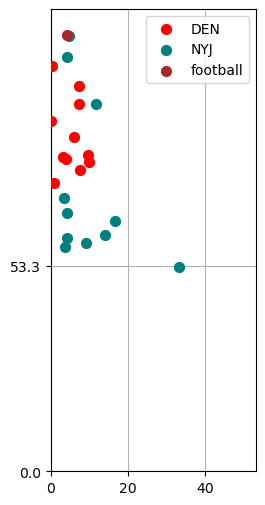

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

class NFLPlayAnimation:
    def __init__(self, tracking_data):
        self.tracking_data = tracking_data
        self.fig, self.ax = plt.subplots(figsize=(10, 6))``
        self.aspect_ratio = 1
        self.y_delta = 45 
        self.x_limit_min = 0
        self.x_limit_max = 53.3

    def plot_field(self):
        """Plot the NFL field layout with square aspect ratio."""
        self.ax.set_xlim(self.x_limit_min, self.x_limit_max)
        self.ax.set_ylim(self.y_limit_min, self.y_limit_min + self.y_delta)
        self.ax.set_aspect(self.aspect_ratio)
        self.ax.set_yticks(range(0, 110, 5))
        self.ax.set_yticks([0, 53.3])
        self.ax.grid(True)

    def init_animation(self):
        """Initialize the animation (empty field)."""
        self.plot_field()
        return self.ax

    def update_frame(self, frame_id):
        """Update the plot for each frame."""
        self.ax.clear()

        frame_data = self.tracking_data[self.tracking_data['frame_id'] == frame_id]

        self.plot_field()
        
        first_club = True
        ball_y = None
        for club, group in frame_data.groupby('club'):
            color = 'red'
            if club == 'football':
                color = 'brown'
                ball_y = group['y'].iloc[0]
            elif not first_club:
                color = 'teal'
            first_club = False
            size = 50
            self.ax.scatter(group['x'], group['y'], color=color, s=size, label=club, zorder=5)

        # Dynamically adjust the y-axis limit if necessary
        if ball_y is not None:
            if ball_y < self.y_limit_min + 10:  # Ball near the bottom
                self.y_limit_min = max(0, ball_y - 10)
            elif ball_y > self.y_limit_min + 35:  # Ball near the top
                self.y_limit_min = min(120 - self.y_delta, ball_y - 35)

            self.ax.set_ylim(self.y_limit_min, self.y_limit_min + self.y_delta)

        self.ax.legend(loc='upper right')
        return self.ax

    def animate_play(self):
        """Create the animation of the play."""
        self.y_limit_min = round(self.tracking_data[(self.tracking_data['club'] == 'football') & (self.tracking_data.event=='ball_snap')]['y'].iloc[0] - 10, 2)

        frame_ids = self.tracking_data['frame_id'].unique()
        
        ani = animation.FuncAnimation(self.fig, self.update_frame, frames=frame_ids, 
                                      init_func=self.init_animation, blit=False, repeat=False)
        return ani

game_id, play_id = 2022102307, 641
# game_id, play_id = 2022102000, 1025
tracking_data = df_tracking.query('game_id == @game_id & play_id == @play_id')

play_anim = NFLPlayAnimation(tracking_data)
ani = play_anim.animate_play()

HTML(ani.to_jshtml(fps=10))

inputs:
- tracking data
- abs los
- yards to go
- 

design principles:
- fast
